# Loading packages

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import random

from models.CAE import CAE
from train import Trainer

from dataloader import ElectricDevices, normalize
from utils import baseline

from scipy.ndimage import gaussian_filter1d

from pingouin import distance_corr # Szekely and Rizzo

import hydra
from hydra.experimental import initialize, initialize_config_dir, compose

from utils import get_shapley_values, get_layer_attrs, get_neuron_attrs

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

# Create Dataset

In [2]:
with initialize_config_dir(config_dir=os.path.abspath("configs")):
    cfg = compose(config_name="config")
print(cfg)

diverging_colors = sns.color_palette("RdBu", 9)

{'model': {'M': 4, 'Lf': 3, 'length': 96, 'bottleneck_nn': 24, 'lmd': 1.0979131326372968e-05, 'alpha': 0.05}, 'train': {'verbose': True, 'shuffle': True, 'batch_size': 64, 'iters': 300, 'early_stopping_rounds': 23, 'lr': 0.001706322160346846}}


## Load observations

In [3]:
data_train_ori, data_valid_ori, data_test_ori = ElectricDevices()
data_train, data_valid, data_test = normalize(data_train_ori), normalize(data_valid_ori), normalize(data_test_ori)
X_train, y_train = data_train[:,:,:-1], data_train[:,:,-1]
X_valid, y_valid = data_valid[:,:,:-1], data_valid[:,:,-1]
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1]

# Data Exploration

# Compare to baseline

In [4]:
%%script false

baseline(data_train, data_valid, data_test)

Couldn't find program: 'false'


# Model

In [5]:
model = CAE(cfg.model, num_classes=7)

In [6]:
# torch.save(model.state_dict(), "../saved_models/mod")
model.load_state_dict(torch.load("../saved_models/mod"))

<All keys matched successfully>

In [ ]:
%%script false

trainer = Trainer(cfg.train)
train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

In [ ]:
%%script false

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

# Checking important filters

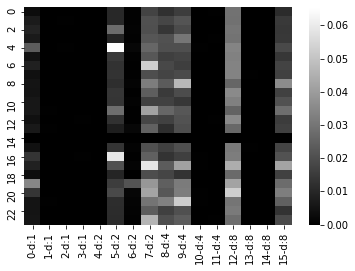

In [6]:
num_filter = model.k*model.M
w_per_filter = model.length
num_neurons = model.bottleneck_nn
M = model.M

w = np.array([[torch.mean(torch.abs(model.encoder.fc_conv_bn.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])
x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])]
# x_axis_labels.append("Input")
# w = np.concatenate((w, torch.mean(model.encoder.full_conv_bn.weight[:,:-96], axis=1).detach().numpy().reshape(24,1)), axis=1)

_ = sns.heatmap(w, xticklabels=x_axis_labels, cmap="gray", vmin=0)

Using as input the arrays with only 1 one

## Average and std correlation

In [15]:
selected = [3279, 1156, 7419, 5046, 3323, 6485,5497]

In [8]:
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1].numpy()
X_testp, outclass_testp, bn = model(X_test, apply_noise=False)
X_testp = X_testp.detach().numpy()
probs_testp = model.classifier.get_probs(outclass_testp)
y_testp = torch.argmax(probs_testp, dim=1).detach().numpy()

# avg and std of cors
cors = [distance_corr(X_testp[i,0], X_test[i,0].detach().numpy(), n_boot=None) for i in range(X_test.shape[0])]
print("Distance Correlation avg and std:", np.mean(cors), np.std(cors))
print("NRMSE:", (torch.sqrt(torch.mean(torch.square(X_test-X_testp)))/(torch.max(X_test)-torch.min(X_test))).item())
print()

Distance Correlation avg and std: 0.731706300394008 0.26447387261251154
NRMSE: 0.19742132723331451



cor: 0.8741527588929695
cor: 0.36311879137222847
cor: 0.9434049445186216
cor: 0.9580858928286433
cor: 0.9783393166779079
cor: 0.9890899896270832
cor: 0.6987556016399546


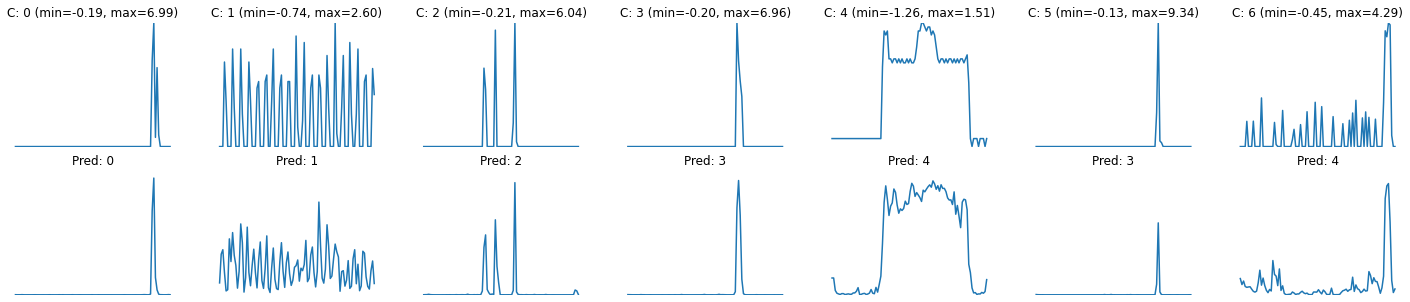

In [11]:
# selected = np.random.choice(range(1000), 7)

fig, axs = plt.subplots(nrows=2, ncols=len(selected), figsize=(25,5))
for i, x in enumerate(selected): #selected):
    vals = data_test_ori[x,0,:-1]
    min_v, max_v = torch.min(vals), torch.max(vals)
    axs[0,i].set_title(f"C: {int(y_test[x][0])} (min={min_v:.2f}, max={max_v:.2f})")
    axs[0,i].plot(X_test[x,0])
    axs[0,i].axis("off")
    axs[0,i].set_ylim((0,1))

    axs[1,i].set_title(f"Pred: {int(y_testp[x])}")
    axs[1,i].plot(X_testp[x,0])
    axs[1,i].axis("off")
    axs[1,i].set_ylim((0,1))

    print("cor:", distance_corr(X_testp[x,0], X_test[x,0], n_boot=None))

Accuracy: 0.6188561794838542


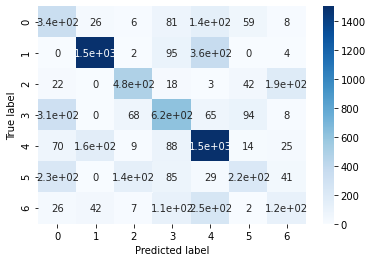

In [12]:
cm = confusion_matrix(y_test, y_testp)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

# Interpretability

## Gradients

<AxesSubplot:>

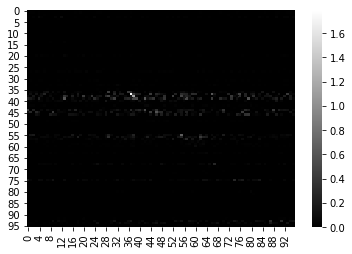

In [15]:
from captum.attr import Saliency
gbp = Saliency(lambda x : model(x)[0])

inp = X_test[7419,:,:].reshape(1,1,96).requires_grad_()

r = []
for i in range(96):
    a = gbp.attribute(inp, target=(0,i))
    r.append(a.detach().numpy().flatten())
sns.heatmap(r, cmap="gray")

## Shapley value

In [ ]:
# %%script false

focus = 0

for j in [1]:
    if j == 0:
        baselines = torch.tensor(gaussian_filter1d(X_test[focus,0], sigma=2)).reshape((1,1,96))
    elif j == 1:
        baselines = 1-X_test[focus].reshape((-1,1,96))
    elif j == 2:
        baselines = torch.ones((1,1,96))
    elif j == 3:
        baselines = torch.zeros((1,1,96))
    else:
        reps = 64
        inp = inp.repeat(reps, 1, 1)
        baselines = torch.rand((reps,1,96))

    # input_attrs = get_shapley_values(inp, model, range(96), baselines)
    input_attrs = get_shapley_values(X_test[3279], lambda x: model(x)[0], range(96), baselines=baselines, target_func=lambda x: (0,x))
    plt.close()
    sns.heatmap(input_attrs, cmap=diverging_colors, center=0).get_figure().savefig(f"../plots/hm_{focus}-{j}.png")
    print()
    print()

In [ ]:
# %%script false

for j in [1]:
    if j == 0:
        baselines = torch.tensor(gaussian_filter1d(X_test[focus,0], sigma=2)).reshape((1,1,96))
    elif j == 1:
        baselines = 1-X_test[focus].reshape((-1,1,96))
    elif j == 2:
        baselines = torch.ones((1,1,96))
    elif j == 3:
        baselines = torch.zeros((1,1,96))
    else:
        reps = 64
        inp = inp.repeat(reps, 1, 1)
        baselines = torch.rand((reps,1,96))

    # input_attrs = get_shapley_values(inp, model, range(96), baselines)
    input_attrs = get_shapley_values(X_test[3279], lambda x: model.encoder(x, False), range(24), baselines=None, target_func=lambda x: x)
    plt.close()
    sns.heatmap(input_attrs, cmap=diverging_colors, center=0).get_figure().savefig(f"../plots/hm_{focus}-{j}.png")
    print()
    print()

In [1]:
from captum.attr import ShapleyValueSampling

input_feature = ShapleyValueSampling(lambda x: model.encoder(x, False))

input_attrs = []
for i in range(24):
    print(i, end=" ")
    baselines = torch.tensor([np.random.binomial(n=1, p=1-x) for x in X_test[3279,0]], dtype=torch.float).reshape(1,1,96)
    attr = input_feature.attribute(X_test[3279].reshape(1,1,96), target=i, baselines=baselines)
    input_attrs.append(attr.detach().numpy().flatten())

In [ ]:
sns.heatmap(input_attrs, cmap=diverging_colors, center=0)

## Layer: importance of bottleneck with respect to output

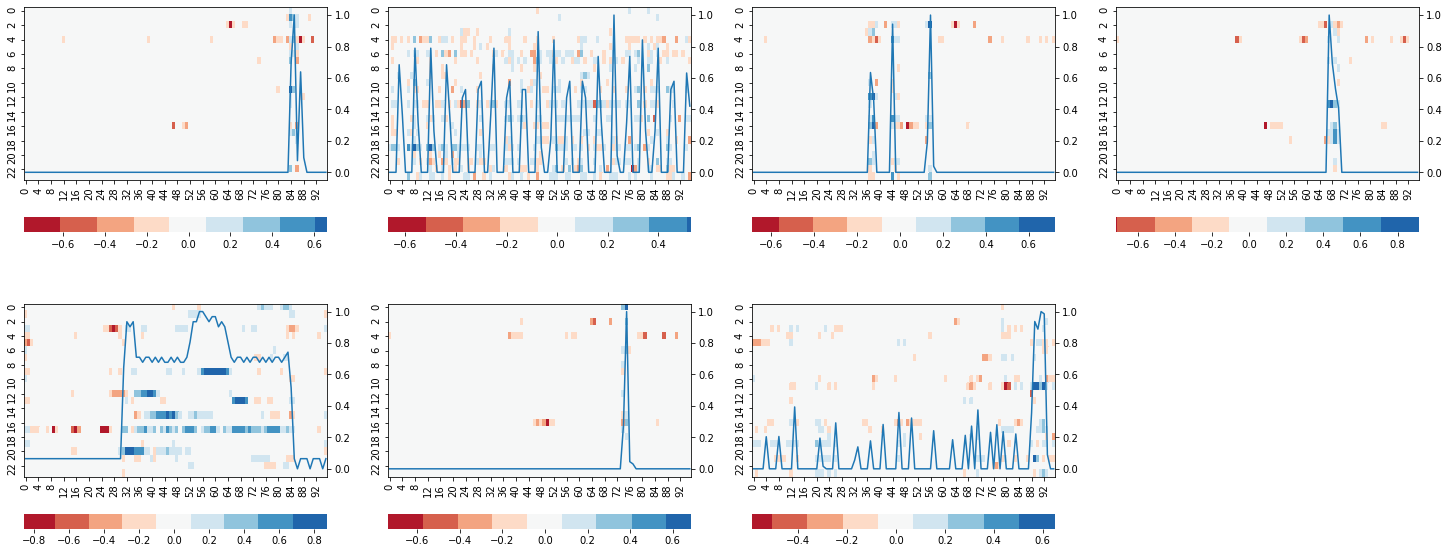

In [16]:
# sns.heatmap(get_layer_attrs(X_test[22], model, model.full_conv_bn, range(96)), cmap="coolwarm") # for row i: attribution of neuron (24) to output i

# bias = torch.nn.functional.leaky_relu(model.encoder.full_conv_bn.bias).reshape(1,1,24)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    layer_attrs = get_layer_attrs(X_test[x], model, model.encoder.last_act, range(96), None)
    ax = sns.heatmap(layer_attrs.T, ax=axs.flat[i], cmap=diverging_colors, center=0, cbar_kws={"orientation": "horizontal"})

    ax = axs.flat[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], ax=ax)
    line = ax.lines[0]
    line.set_xdata(line.get_xdata()+0.5)

## importance of input with respect bottleneck

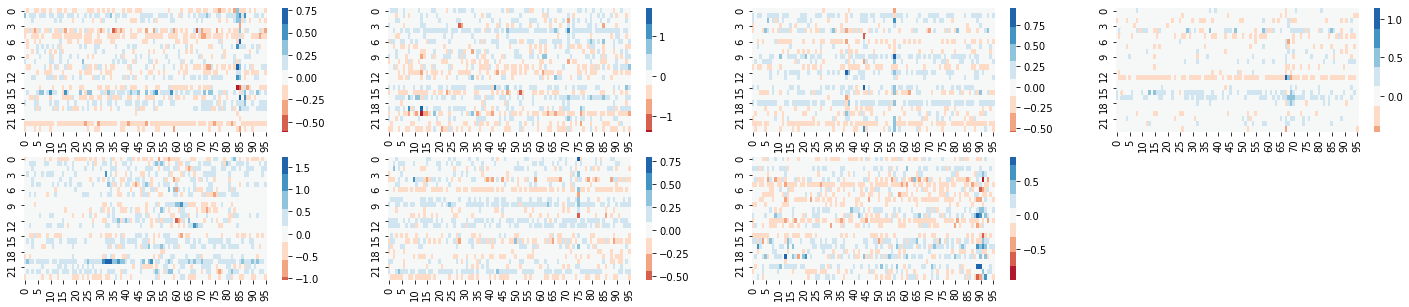

In [15]:
# sns.heatmap(get_neuron_attrs(X_test[22], model, model.full_conv_bn, range(24)), cmap="coolwarm")

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,5))
axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    neuron_attrs = get_neuron_attrs(X_test[x], model, model.encoder.last_act, range(24))
    sns.heatmap(neuron_attrs, ax=axs.flat[i], cmap=diverging_colors, center=0)

# Feature Visualization

In [ ]:
# %%script false

def feature_visualization(neuron): # https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    X = torch.rand((1,1,96), requires_grad=True)
    optimizer = optim.LBFGS([X])

    def closure():
        optimizer.zero_grad()
        model.zero_grad()
        _, _, bn = model(torch.sigmoid(X), apply_noise=False)
        y = -bn[0,neuron]
        y.backward()
        return y

    for i in range(100):
        optimizer.step(closure)
    return torch.sigmoid(X).detach().numpy().flatten()

for i in range(24):
    a1 = feature_visualization(i)
    plt.plot(a1, "o-")
    plt.title(f"Neuron {i}")
    plt.ylim(-0.05, 1.05)
    plt.savefig(f"../plots/{i}.png")
    plt.close()

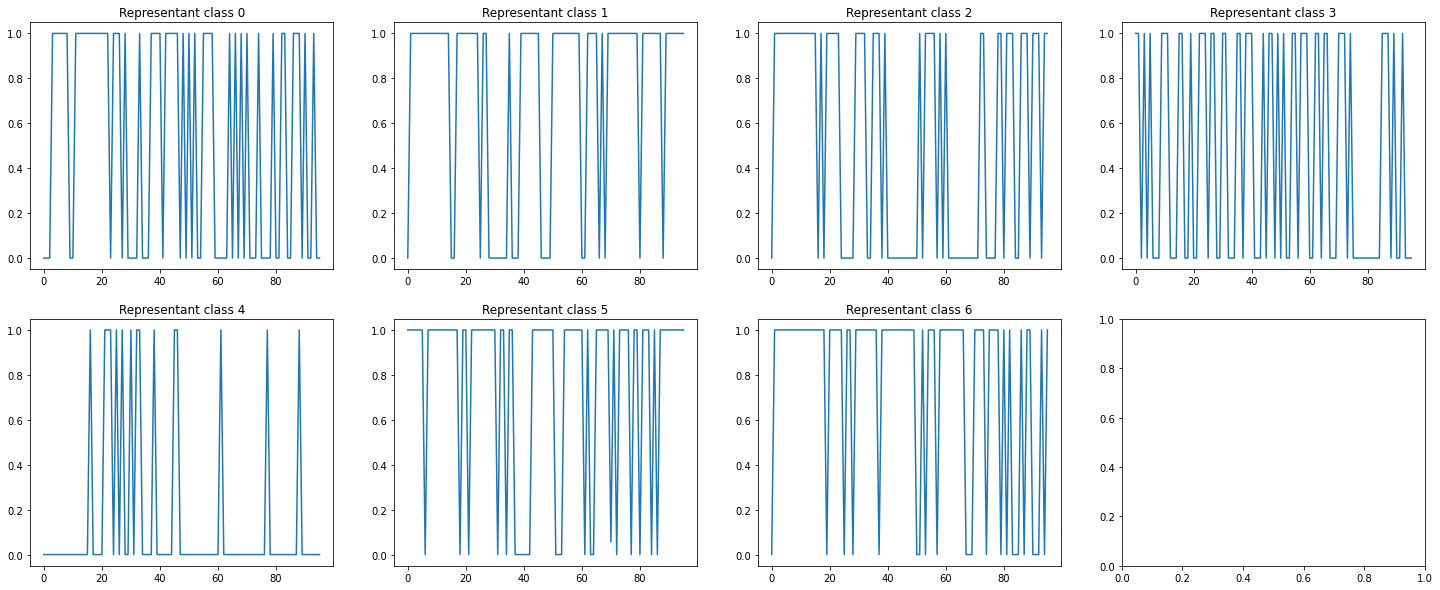

In [20]:
# %%script false

def feature_visualization(clss): # https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    X = torch.rand((1,1,96), requires_grad=True)
    optimizer = optim.LBFGS([X])

    def closure():
        optimizer.zero_grad()
        model.zero_grad()
        _, pred_class, _ = model(torch.sigmoid(X), apply_noise=False)
        y = -pred_class[0,clss]
        y.backward()
        return y

    for i in range(100):
        optimizer.step(closure)
    return torch.sigmoid(X).detach().numpy().flatten()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
for i in range(7): #selected):
    a1 = feature_visualization(i)
    axs.flat[i].plot(a1)
    axs.flat[i].set_title(f"Representant class {i}")
    axs.flat[i].set_ylim(-0.05, 1.05)


# TODO: Shapley Value Sampling

In [9]:
def shapley_sampling(x, model, feature, n_batches=1, batch_size=64):
    length = x.shape[-1]
    sv = torch.zeros(length)

    x = x.reshape(1, length).repeat(batch_size, 1)
    for _ in range(n_batches):
        y = torch.rand((batch_size, length))
        O = np.array([np.random.permutation(length) for _ in range(batch_size)])
        idx = np.where(O == feature)
        Os = [O[i,:j] for i, j in zip(idx[0], idx[1])]

        sel = torch.zeros((batch_size,length), dtype=torch.bool)
        sel[np.concatenate([np.repeat(i,len(Os[i])) for i in range(batch_size)]), np.concatenate(Os)] = True

        x2 = torch.where(sel, x, y)
        x1 = x2.clone()
        x1[:,feature] = x[:,feature]

        x1 = x1.reshape(-1,1,length)
        x2 = x2.reshape(-1,1,length)
        with torch.no_grad():
            v1 = model(x1, False)[0][:,0]
            v2 = model(x2, False)[0][:,0]
        sv += torch.sum(v1 - v2, axis=0)

    sv /= n_batches*batch_size
    return sv.numpy()

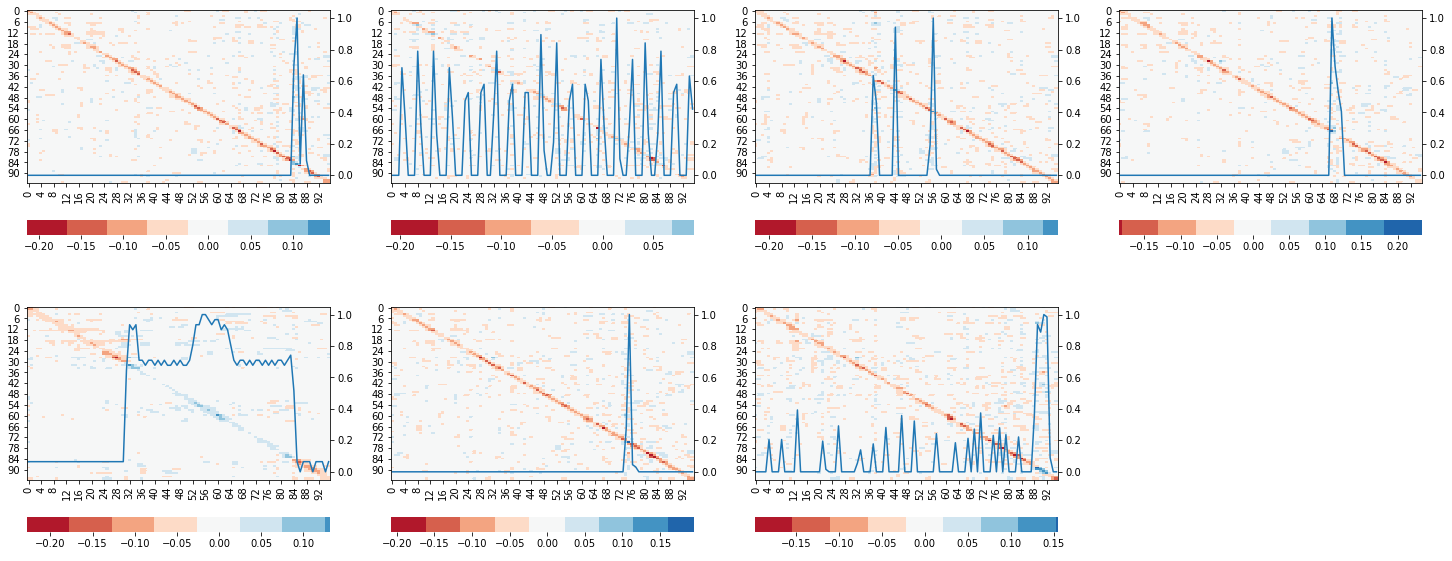

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    attrs = [shapley_sampling(X_test[x,0], model, feature=j, n_batches=10) for j in range(96)]
    sns.heatmap(attrs, ax=axs.flat[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})

    ax = axs.flat[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], ax=ax)
    line = ax.lines[0]
    line.set_xdata(line.get_xdata()+0.5)

Importance of bottleneck with respect the outputs

In [26]:
def shapley_sampling_bottleneck(x, model, feature, n_batches=1, batch_size=64):
    sv = torch.zeros(x.shape[-1])
    x = model.encoder(x.reshape(1,1,96), False) # bottleneck
    length = x.shape[-1]
    for _ in range(n_batches):
        y = torch.zeros((batch_size, length)) # changed
        O = np.array([np.random.permutation(length) for _ in range(batch_size)])
        idx = np.where(O == feature)
        Os = [O[i,:j] for i, j in zip(idx[0], idx[1])]

        sel = torch.zeros((batch_size,length), dtype=torch.bool)
        sel[np.concatenate([np.repeat(i,len(Os[i])) for i in range(batch_size)]), np.concatenate(Os)] = True

        x2 = torch.where(sel, x, y)
        x1 = x2.clone()
        x1[:,feature] = x[:,feature]

        x1 = x1.reshape(-1,1,length)
        x2 = x2.reshape(-1,1,length)
        with torch.no_grad():
            v1 = model.decoder(x1)[:,0]
            v2 = model.decoder(x2)[:,0]
        sv += torch.sum(v1 - v2, axis=0)

    sv /= n_batches*batch_size
    return sv.numpy()

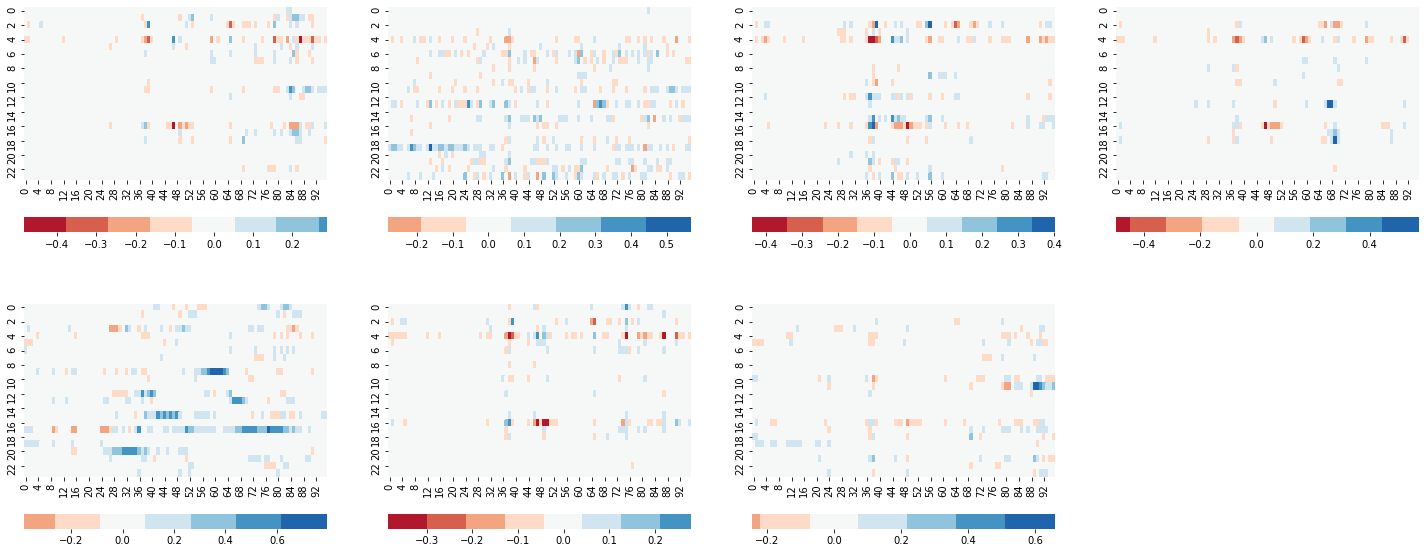

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    layer_attrs = np.array([shapley_sampling_bottleneck(X_test[x,0], model, feature=j, n_batches=10) for j in range(24)])
    ax = sns.heatmap(layer_attrs, ax=axs.flat[i], cmap=diverging_colors, center=0, cbar_kws={"orientation": "horizontal"})

aaaaa

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58

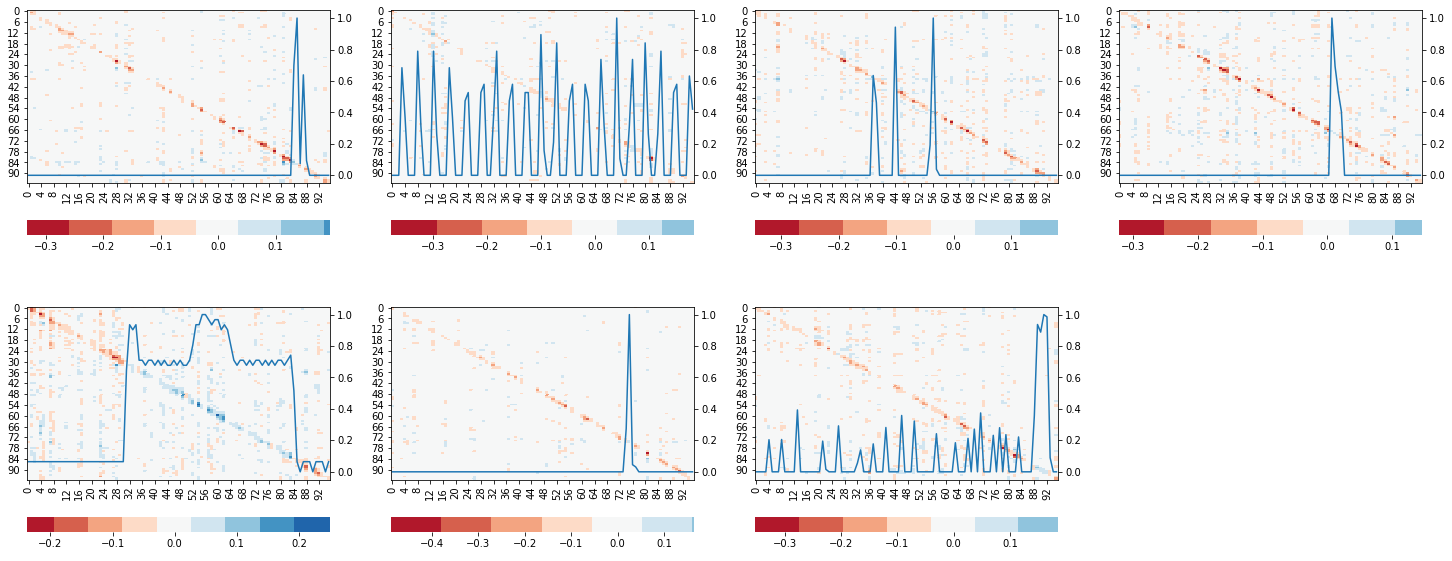

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    baselines = torch.rand((1,1,96))

    attrs = get_shapley_values(X_test[x], lambda x: model(x)[0], range(96), baselines=baselines, target_func=lambda x: (0,x))
    sns.heatmap(attrs, ax=axs.flat[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})

    ax = axs.flat[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], ax=ax)
    line = ax.lines[0]
    line.set_xdata(line.get_xdata()+0.5)

# New

In [10]:
_, _, bn = model(X_train, False)
bn = bn.detach().numpy()

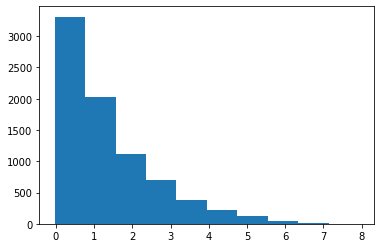

In [24]:
_ = plt.hist(bn[:,12])